# Exercises

---

## Exercise 1: structured and ustructured images
Write a function that outputs the number of PC you have to choose to retain a given percentage of explained variance.
Use this funtion on the  handwritten digit data, and plot the number of PC needed to retain a certain fraction of EVR, for a few vaules of EVR.

Compare this curve to the one you can obtain in unstructured images: either generate images with the same shape of our data or randomly permute the pixels in each image independenlty. How does the number of PC needed to retain a certain fraction of the variance in this case compare to the number needed for digit images?

In [1]:
import numpy as np
from scipy import io
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pylab as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

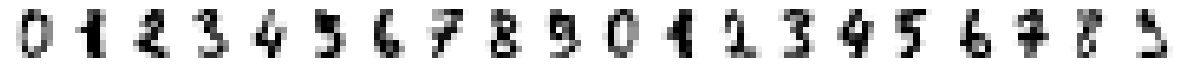

In [2]:
# load image data
dataset = load_digits()
images = dataset.data

#plot first 20 images
plt.figure(figsize=(15,7))
for i,img in enumerate(images[:20]):
    plt.subplot(1,20,i+1)
    plt.imshow(img.reshape(8,8),cmap=plt.cm.Greys)
    plt.axis('off')

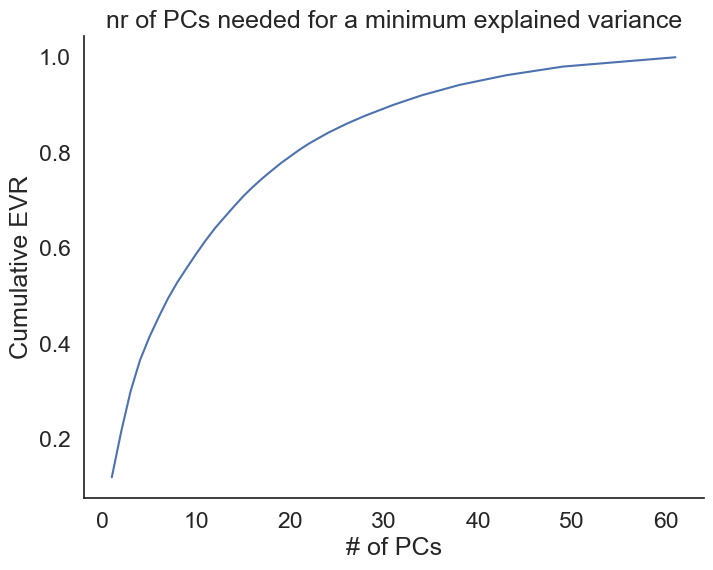

In [3]:
def nr_of_pc(min_var, images):
    # defines a scaler objects
    scaler = StandardScaler()
    # z-score with fit_transform method
    X =scaler.fit_transform(images)
    # fit pca
    pca = PCA()
    pca.fit(X)
    max_len = len(pca.explained_variance_ratio_)
    cumulative_evar = np.cumsum(pca.explained_variance_ratio_)
    for i, evar in enumerate(cumulative_evar):
        if evar >= min_var:
            return i+1, evar
        elif i + 1 == max_len:
            return i+1, evar

var_len = 50
variances = np.linspace(0, 1, var_len)
e_variances = np.zeros(var_len)
nrofpcs = np.zeros(var_len)

for i, v in enumerate(variances):
    nrofpcs[i], e_variances[i] = nr_of_pc(v, images)

plt.figure(figsize = (8,6))
plt.title('nr of PCs needed for a minimum explained variance')
plt.xlabel('# of PCs')
plt.ylabel('Cumulative EVR')
plt.plot(nrofpcs, e_variances)
plt.show()

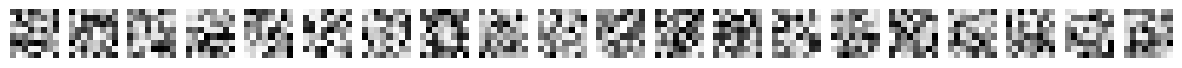

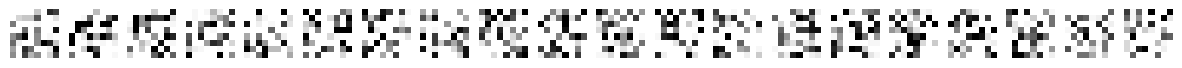

In [4]:
def generate_random_images(images):
    return np.random.rand(*images.shape)

random_images = generate_random_images(images)

#plot first 20 images of the random images
plt.figure(figsize=(15,7))
for i,img in enumerate(random_images[:20]):
    plt.subplot(1,20,i+1)
    plt.imshow(img.reshape(8,8),cmap=plt.cm.Greys)
    plt.axis('off')

# permute the pixels of the original images
def permute_image_pixels(images):
    permuted_images = images.copy()
    for i in range(images.shape[0]):
        permuted_images[i] = np.random.permutation(images[i])
    return permuted_images

permuted_images = permute_image_pixels(images)

#plot first 20 images of the permuted images
plt.figure(figsize=(15,7))
for i,img in enumerate(permuted_images[:20]):
    plt.subplot(1,20,i+1)
    plt.imshow(img.reshape(8,8),cmap=plt.cm.Greys)
    plt.axis('off')

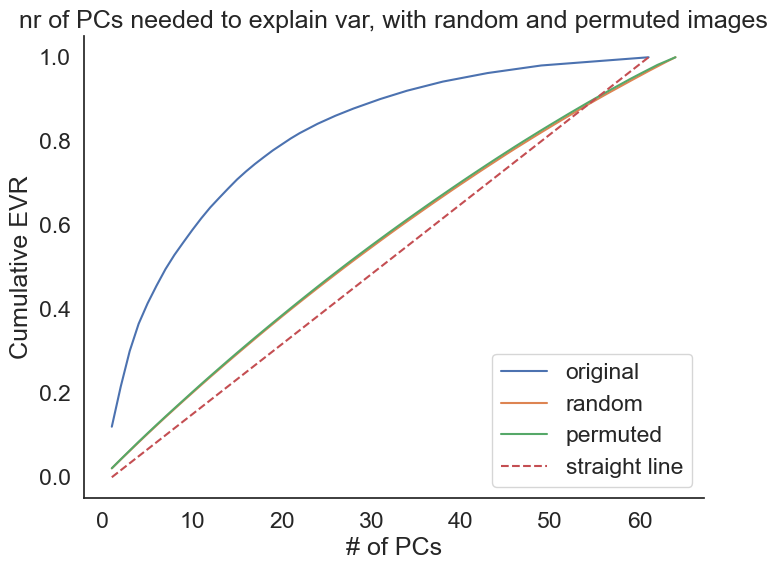

In [5]:
# initiate the variances and the arrays to store the calculated variances and required number of pcs
var_len = 50
variances = np.linspace(0, 1, var_len)
e_variances = np.zeros(var_len)
nrofpcs = np.zeros(var_len)
e_variances_random = np.zeros(var_len)
nrofpcs_random = np.zeros(var_len)
e_variances_permuted = np.zeros(var_len)
nrofpcs_permuted = np.zeros(var_len)

# calculate the number of pcs, and corresponding (exact) expected variance, for the different variances
for i, v in enumerate(variances):
    nrofpcs[i], e_variances[i] = nr_of_pc(v, images)
    nrofpcs_random[i], e_variances_random[i] = nr_of_pc(v, random_images)
    nrofpcs_permuted[i], e_variances_permuted[i] = nr_of_pc(v, permuted_images)

plt.figure(figsize = (8,6))
plt.title('nr of PCs needed to explain var, with random and permuted images')
plt.xlabel('# of PCs')
plt.ylabel('Cumulative EVR')
plt.plot(nrofpcs, e_variances, label = 'original')
plt.plot(nrofpcs_random, e_variances_random, label = 'random')
plt.plot(nrofpcs_permuted, e_variances_permuted, label = 'permuted')
plt.plot(np.linspace(1,61,61), np.linspace(0,1,61), ls = '--', label = 'straight line')
plt.legend()
plt.show()

The first few components of PCA on the original images explain much more variance than the first few components of the PCA on the random or permuted images. Every component after the first few explains less and less variance. This is also the case for the random and permuted images, however the difference is not significant. Another way to think about it is that the EVR of the PCA on the generated images is just random and then sorted from high EVR to low EVR. This wont result in an entirely straight line, as one might think, but a line with a small curvature. Because there will be some fluctuations due to the randomness of the data.

Also keep in mind that the number of PCs is not the same between the different datasets as the fit is different. The original PCA results in 61 components, while the random ones result in about 64 components (so the straight line is not completely correct for all datasets).

## Exercise 2: cortical dynamics

Work with the cortical data we used in the lesson. Write some code that lets you easily chose a specific behavioural event from the `trial_data` dictionary (the recorded events are `CSp` for positive conditioned stimulus, `CSn` for negative conditioned stimulus and `licks` for lick events), one of the principal components, an onset time and and offset time, and plots the timecourse of this component in the selected period around the chosen event type.

Use this code to explore the data: how do different components behave? Do you notice any patterns? How would you test for the statistical significance of the effects that you see (if any)?

In [6]:
import pickle

with open('./data/behaviour.pickle', 'rb') as handle:
    trial_data = pickle.load(handle)

voltage_signal = np.load('./data/voltage_signal.npy')
cortex_mask = np.load('./data/cortex_mask.npy')

In [7]:
X = voltage_signal.transpose(2,0,1) # reshape in time x image format
T,h,w = X.shape # saves time, height and width for future use
X = X[:,cortex_mask] # select only cortex pixels, returns a flattened image

In [8]:
pca = PCA(n_components=50);
pca.fit(X)

PCA(n_components=50)

In [9]:
PCs = pca.components_[:10,:].T # select and transpose first 10 PCs weights
X_pca = X @ PCs # compute the PC timecourse, by projecting the original data on each component

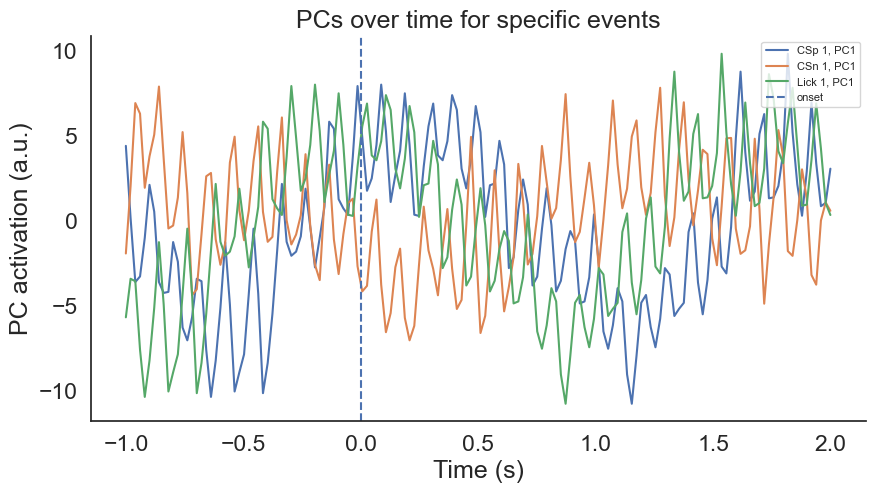

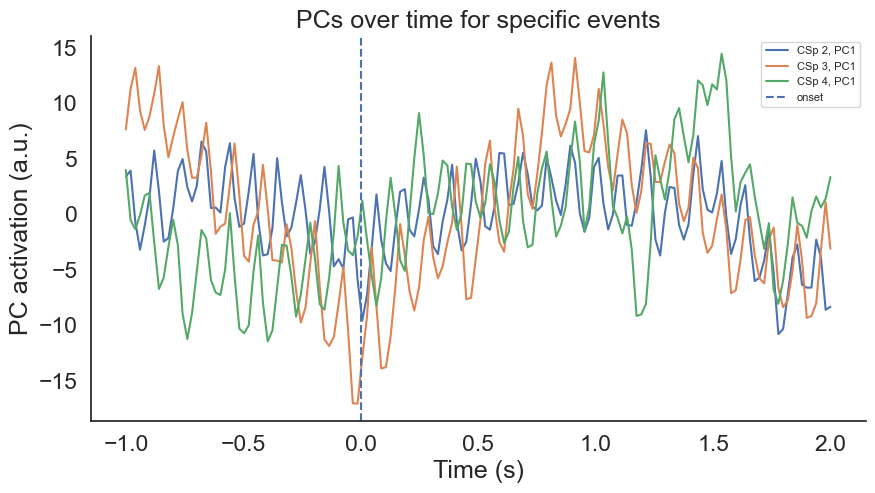

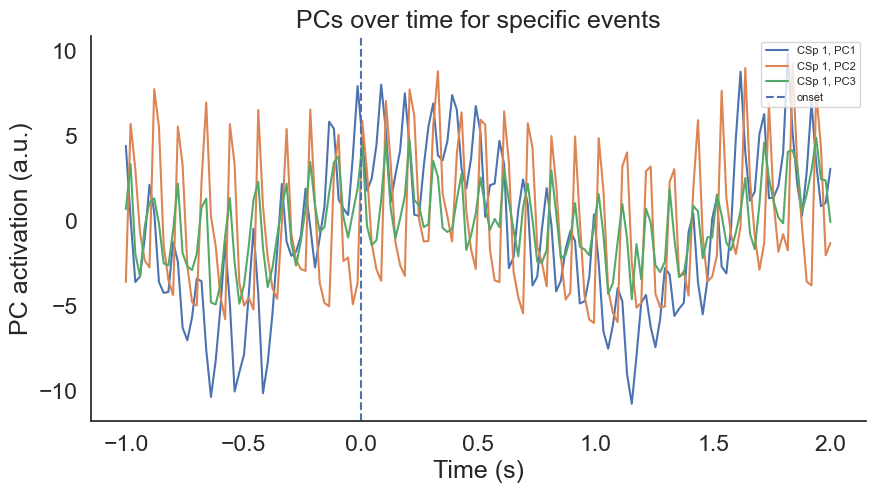

In [10]:
# eventtype = 1 for CSp, =2 for CSn and =3 for licks
# also needs to be a global variable, in order to be used in other functions
events = {1: 'CSp', 2: 'CSn', 3: 'Lick'}

# outputs the trial_data of the specific event type and number
def choose_event(eventtype, index, data=trial_data):
    if eventtype not in events:
        print("Invalid event type")
        return None
    
    event_name = events[eventtype]
    if index + 1 > len(data[event_name]):
        print(f'Error: out of range {len(data[event_name])}')
        return None
    else:
        return data[event_name][index]

# outputs the pca data of the chosen event and time frame
def pca_over_time(eventtype, index, pc_index, start_time, end_time, pca_data, data=trial_data):
    frame_times = trial_data['frames'] #frame times
    
    i = choose_event(eventtype, index, data)
    onset_frame = np.argmin(abs(frame_times-i)) #take frame closest to onset
    start_frame = int(onset_frame + framerate*start_time/1.000) # compute starting frame
    end_frame = int(onset_frame + framerate*end_time/1.000) # compute ending frame
    
    return pca_data[start_frame:end_frame, pc_index]
    
# takes params as an input, which is a matrix made up of row vectors with 3 entries
# each vector contains the eventtype, event index and component number
# other variables are the on and offset timings or in other words the start and end time of the timeframe around the onset
# by default uses the pca_data and trial_data variables, but can be made to use other data as well
def plot_pca_over_time(params, start_time, end_time, pca_data = X_pca, data = trial_data):
    plt.figure(figsize=(10, 5))
    plt.title(f'PCs over time for specific events')
    for i, p in enumerate(params):
        eventtype, index, pc_index = p
        pca_ot = pca_over_time(eventtype, index, pc_index, start_time, end_time, pca_data, data)
        t = np.linspace(start_time, end_time, len(pca_ot))
        plt.plot(t, pca_ot, label = f'{events[eventtype]} {index+1}, PC{pc_index+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('PC activation (a.u.)')
    plt.axvline(x=0,linestyle='--',label='onset')
    plt.legend(loc=1, prop={'size': 8})
    plt.show()    

framerate = 50. #in Hz

params = [[1, 0, 0],
          [2, 0, 0],
          [3, 0, 0]]

plot_pca_over_time(params, start_time=-1, end_time=2)

params = [[1, 1, 0],
          [1, 2, 0],
          [1, 3, 0]]

plot_pca_over_time(params, start_time=-1, end_time=2)

params = [[1, 0, 0],
          [1, 0, 1],
          [1, 0, 2]]

plot_pca_over_time(params, start_time=-1, end_time=2)

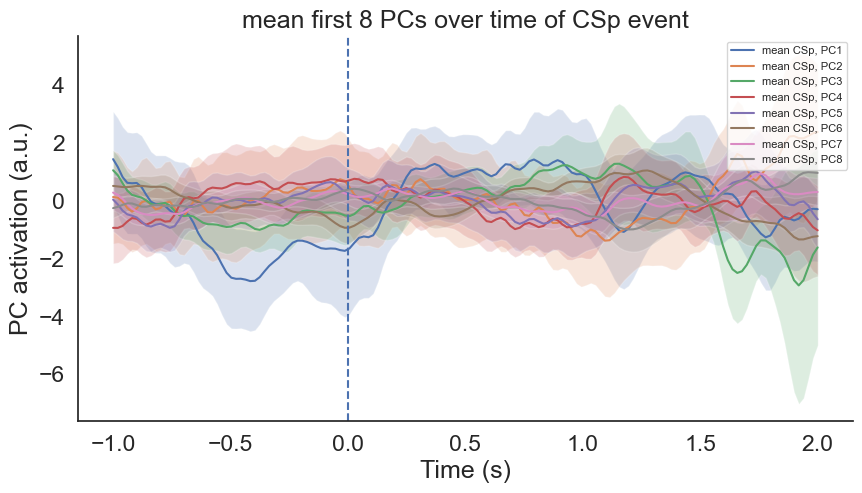

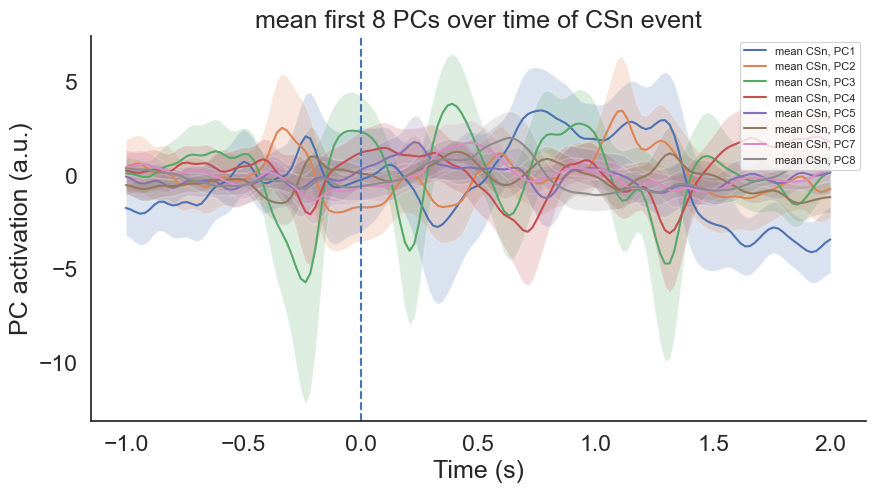

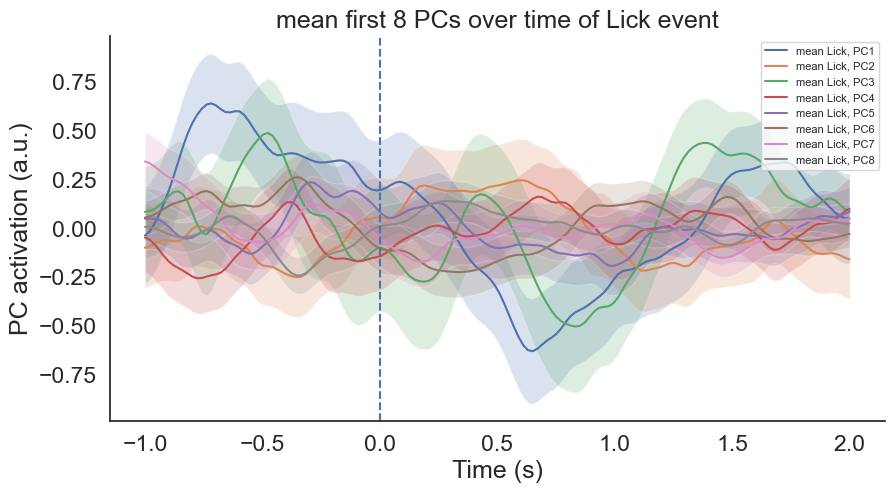

In [11]:
# Plot the mean and std over the different eventtypes and over the different pcs
from scipy.ndimage import gaussian_filter1d
from scipy.stats import sem

start_time = -1
end_time = 2
eventtypes = [1,2,3]
max_frames = int((end_time - start_time) * framerate)
t = np.linspace(start_time, end_time, max_frames)

pcs_ot_for_all_events = []
for k, eventtype in enumerate(eventtypes):
    nr_of_events = len(trial_data[events[eventtype]])
    pcs_ot = np.zeros((X_pca.shape[1], nr_of_events, max_frames))
    for pc_index in range(X_pca.shape[1]):
        for i in range(nr_of_events):
            pcs_ot[pc_index, i, :] = pca_over_time(eventtype, i, pc_index, start_time, end_time, pca_data = X_pca)
    pcs_ot_for_all_events.append(pcs_ot)

# Show differences between PCs for same event type
for k, eventtype in enumerate(eventtypes):
    plt.figure(figsize = (10,5))
    pcs_ot = pcs_ot_for_all_events[k]
    y = np.mean(pcs_ot, axis = 1)
    err = sem(pcs_ot, axis = 1)
    
    # plot 5 pcs
    pc_range = 8
    for j in range(pc_range):
        y_j = gaussian_filter1d(y[j], 2)
        err_j = gaussian_filter1d(err[j], 2)
        plt.plot(t, y_j, label = f'mean {events[eventtype]}, PC{j+1}')
        plt.fill_between(t, y_j-err_j, y_j+err_j,alpha=0.2)
    plt.title(f'mean first {pc_range} PCs over time of {events[eventtype]} event')
    plt.xlabel('Time (s)')
    plt.ylabel('PC activation (a.u.)')
    plt.legend(loc=1, prop={'size': 8})
    plt.axvline(x=0,linestyle='--',label='onset')
    plt.show()

I think notably, the first and third component in the Lick event, show a peak right before the onset and the second component shows a trough. After which the opposite seems to be true (peak becomes trough and vice versa).
Besides that, the lower rank PCs seem to have a lower error and not fluctuate as much.

Furthermore, in the CSn event, the PCs start to oscilate, right before the onset, and continue until the end of the timeframe (at 2s).

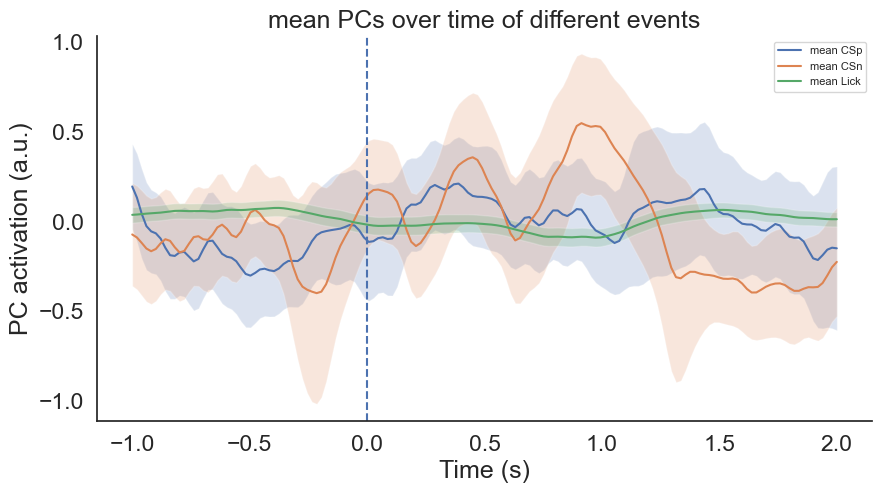

In [12]:
# Show differences between different event types (take mean over PCs as well)
plt.figure(figsize = (10,5))
for k, eventtype in enumerate(eventtypes):
    pcs_ot = pcs_ot_for_all_events[k]
    y = np.mean(np.mean(pcs_ot, axis = 0), axis = 0)
    err = sem(np.mean(pcs_ot, axis = 0), axis = 0)

    y = gaussian_filter1d(y, 2)
    err = gaussian_filter1d(err, 2)
    plt.plot(t, y, label = f'mean {events[eventtype]}')
    plt.fill_between(t, y-err, y+err,alpha=0.2)
plt.title(f'mean PCs over time of different events')
plt.xlabel('Time (s)')
plt.ylabel('PC activation (a.u.)')
plt.legend(loc=1, prop={'size': 8})
plt.axvline(x=0,linestyle='--',label='onset')
plt.show()

Confirming earlier observations, the PCs of the CSn event start oscilation several moments before the onset.

A drop and then a peak in the PC activation can be seen for the CSp event. Decreasing before the onset and then increasing after the event.

The mean PC activation is noticably smaller (closer to 0) for the Lick events than for the other two. The standard error of the mean PCs over time of the Lick events is also much smaller. The mean PCs of the Lick event seems to be above 0 before the onset and then leading up to it start to gradually decrease towards a negative PC activation after the onset. Reaching its minimum around 1s after the onset. The differences seem only very minor on the scale of this graph, however you have to keep in mind that the error is much lower than for the other two events. Another plot might show a bit more detail (see below).

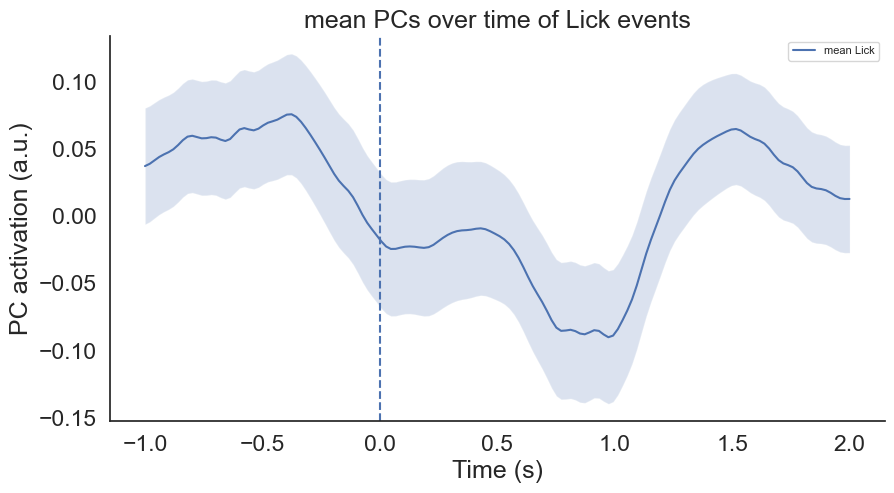

In [13]:
plt.figure(figsize = (10,5))
plt.plot(t, y, label = f'mean {events[eventtype]}')
plt.fill_between(t, y-err, y+err,alpha=0.2)
plt.title(f'mean PCs over time of Lick events')
plt.xlabel('Time (s)')
plt.ylabel('PC activation (a.u.)')
plt.legend(loc=1, prop={'size': 8})
plt.axvline(x=0,linestyle='--',label='onset')
plt.show()

This plot provides a lot more detail and confirms the earlier observations. Also it can now clearly be seen that the value "resets" a few seconds after the lick event.

Statistical significance can be tested by doing a t-test. But it can also be done by shuffling the data to create a null hypothesis or control.



## Exercise 3: nonlinear dimensionality reduction

Using the MNIST digit dataset, explore the effect of hyperparameters on the result of nonlinear dimensionality reduction methods.

- Change the `perplexity` and `exageration` parameters in `TNSE` (one at a time). Graphically compare the results of different values.
- Change the neighbourhood size in `Isomap` (set by the parameter `n_neighbors`), and visualize how the results change.

Finally, try to apply one or more of these methods to the cortical data we used in the lessons. How do the data look in two dimensions? Do any cluster seem to appear? Are they robust with respect to hyperparameter choice?

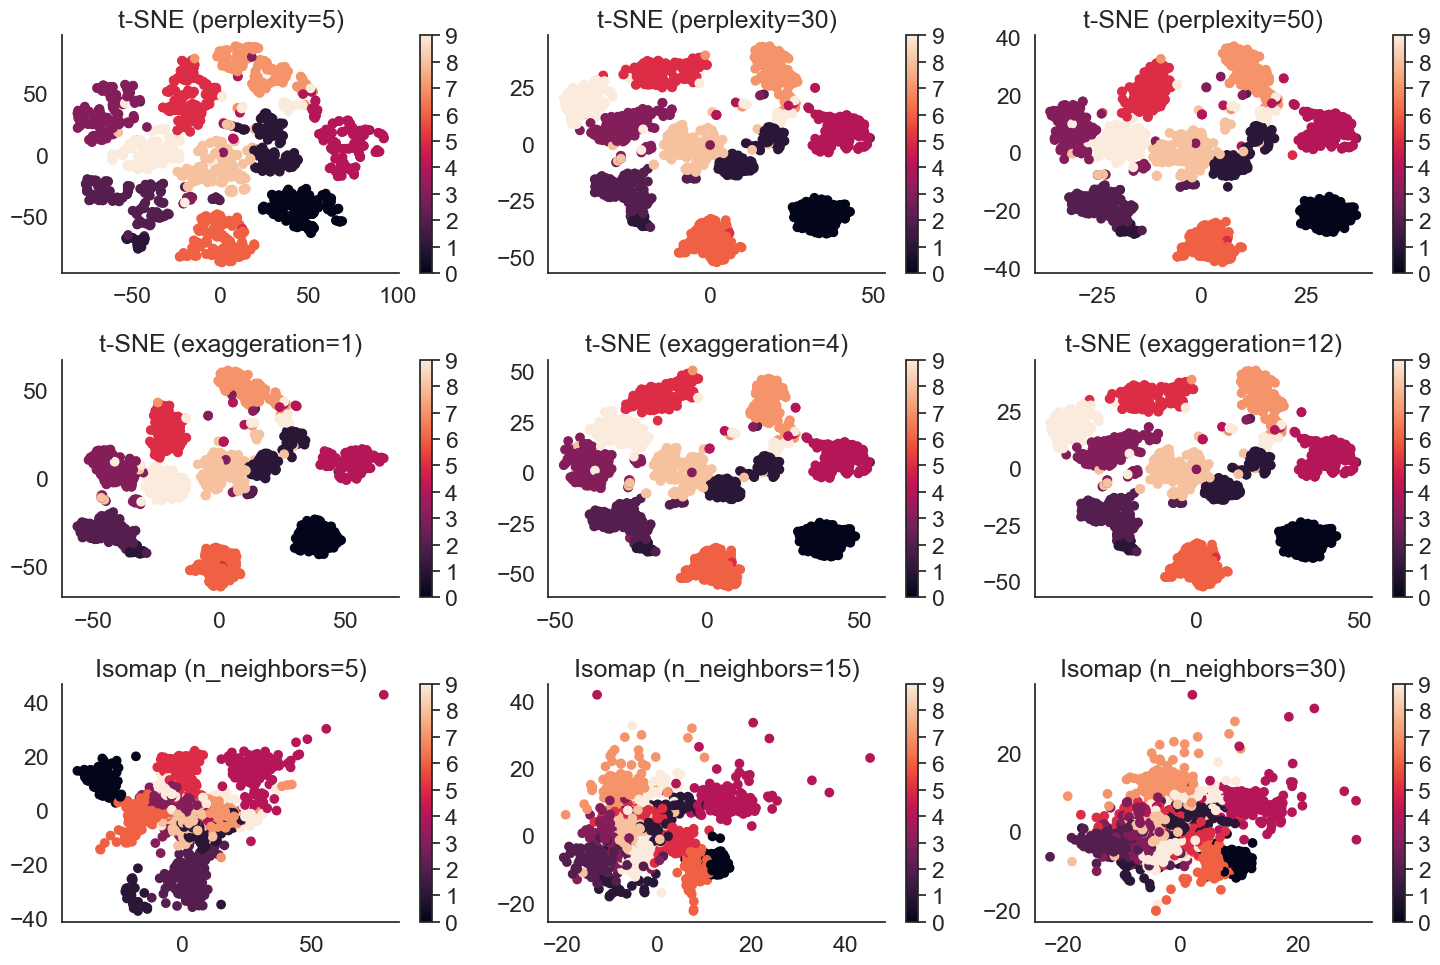

In [14]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap

# reload the images
dataset = load_digits()
images = dataset.data
X = StandardScaler().fit_transform(images)

# hyperparameters
perplexities = [5, 30, 50]
exaggerations = [1, 4, 12]
n_neighbors_values = [5, 15, 30]

plt.figure(figsize=(15, 10))

# t-SNE with different perplexities
for i, perplexity in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0)
    X_tsne = tsne.fit_transform(X)
    plt.subplot(3, 3, i + 1)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dataset.target)
    plt.title(f't-SNE (perplexity={perplexity})')
    plt.colorbar(ticks = list(range(10)))

# t-SNE with different exaggerations
for i, exaggeration in enumerate(exaggerations):
    tsne = TSNE(n_components=2, early_exaggeration=exaggeration, random_state=0)
    X_tsne = tsne.fit_transform(X)
    plt.subplot(3, 3, i + 4)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dataset.target)
    plt.title(f't-SNE (exaggeration={exaggeration})')
    plt.colorbar(ticks = list(range(10)))

# isomap with different n_neighbors
for i, n_neighbors in enumerate(n_neighbors_values):
    isomap = Isomap(n_components=2, n_neighbors=n_neighbors)
    X_iso = isomap.fit_transform(X)
    plt.subplot(3, 3, i + 7)
    plt.scatter(X_iso[:, 0], X_iso[:, 1], c=dataset.target)
    plt.title(f'Isomap (n_neighbors={n_neighbors})')
    plt.colorbar(ticks = list(range(10)))

plt.tight_layout()
plt.show()

The clustering seems to improve for tSNE as the perplexity goes up. At perplexity = 5, gaps can be observed within each cluster. However, the separation between certain classes, such as 3 and 9 (top left), seems to be slightly better at a lower perplexity. Surprisingly enough these also swap places at perplexity = 30. For the classes 0 (bottom right) and 6 (bottom middle) thought the separation is visibly better at the higher perplexities.

For the exaggeration, I do not notice a big difference between the plots. The a lower exaggeration seems a to group the clusters a little bit more, however for each value of the parameter the method seems to fit pretty decently. Interestingly, the datapoints corresponding to class 1, can be seen scattered in the middle. Some of which lean more towards 7 and some more towards 8. The separation between the two clusters of this class seems to slightly increase at exaggeration = 12.

The isomap method seems to work the best at a lower n_neighbors of n=5. The clustering is not as clear as in TSNE, but that is to be expected, as TSNE easily (and sometimes falsly) clusters data. At the higher number of neighbors the data clusters overlap each other for the majority and only a couple classes can be clearly observed. What's also interesting is that the class 5 (top middle in the left plot, n=5) is pretty clearly visible for the n=5 plot, however it gets lost in the center of the data for the other two values of n_neighbors.

Preprocessed the data
tsne fit done!
isomap fit done!


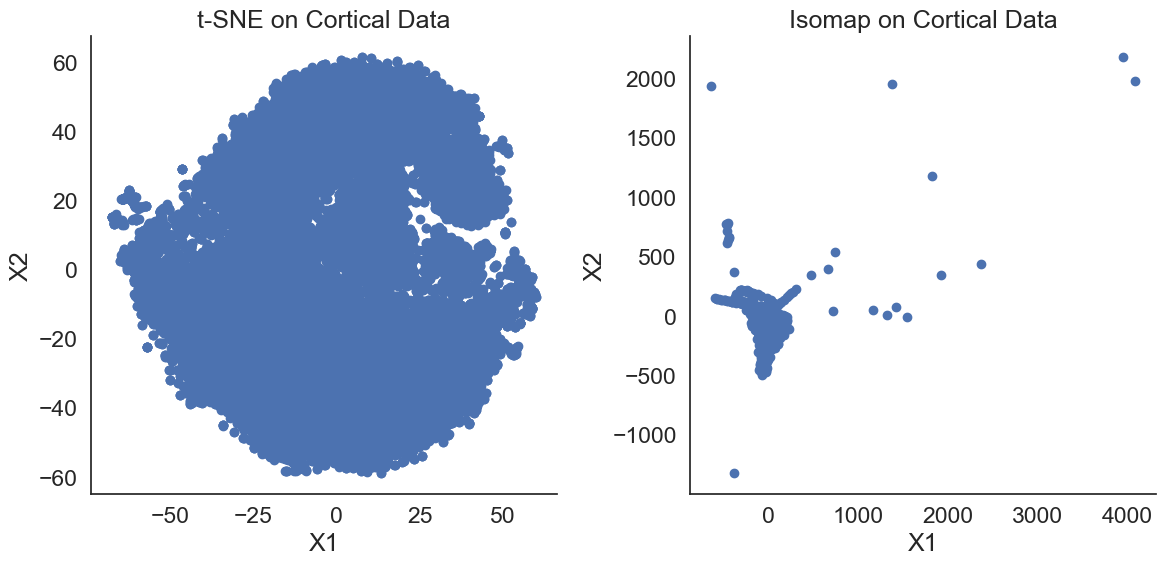

In [15]:
# Preprocess the cortical data (computationally intensive)
X = voltage_signal.transpose(2,0,1) # reshape in time x image format
T,h,w = X.shape # saves time, height and width for future use
X = X[:,cortex_mask] # select only cortex pixels, returns a flattened image
X = StandardScaler().fit_transform(X)
print("Preprocessed the data")

# you can take a slice instead of the whole data because 29999 images of about 300 pixels is quite a lot
X_slice = X[:]

# Apply t-SNE and Isomap to the cortical data
tsne = TSNE(n_components=2, perplexity=50, early_exaggeration = 20, random_state=0)
X_tsne = tsne.fit_transform(X_slice)
print("tsne fit done!")
isomap = Isomap(n_components=2, n_neighbors=5)
X_iso = isomap.fit_transform(X_slice)
print("isomap fit done!")
# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('t-SNE on Cortical Data')
plt.xlabel('X1')
plt.ylabel('X2')

plt.subplot(1, 2, 2)
plt.scatter(X_iso[:, 0], X_iso[:, 1])
plt.title('Isomap on Cortical Data')
plt.xlabel('X1')
plt.ylabel('X2')

plt.tight_layout()
plt.show()

This data does not show a whole lot, to be honest, let's vary the hyperparameters and look at a slice of the data instead.

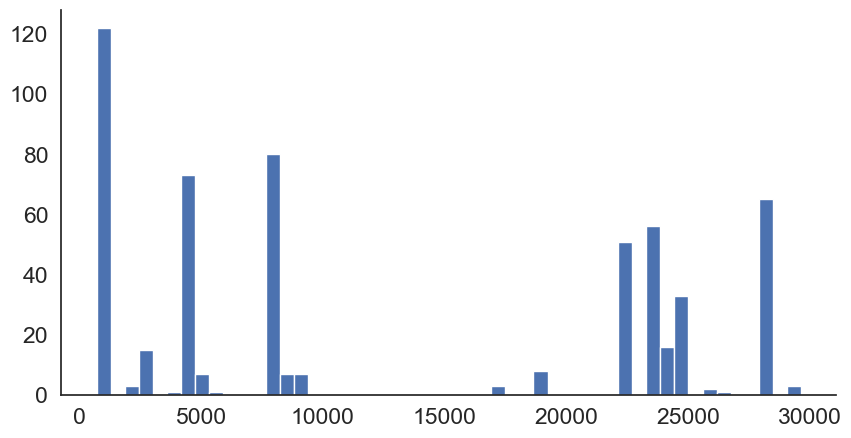

In [16]:
plt.figure(figsize = (10,5))
plt.hist(trial_data['Lick']/401, bins = 50)
plt.xticks(list(range(0,30001,5000)))
plt.show()

tsne perplexity fit done!
tsne exaggeration fit done!
isomap fit done!


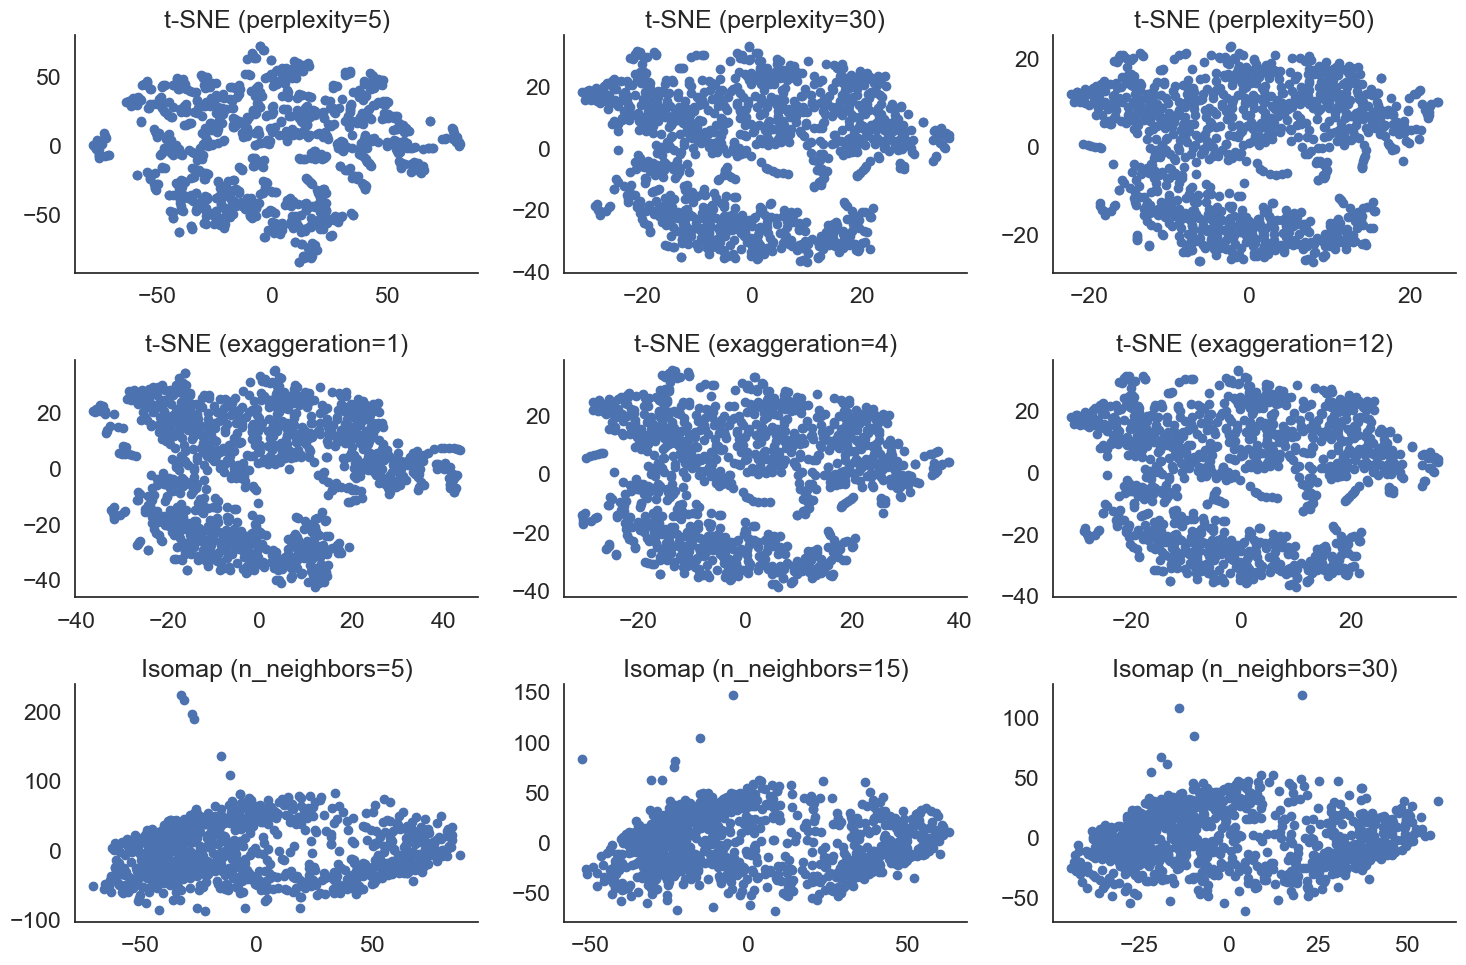

In [17]:
# We choose a slice according to the plot above
X_slice = X[7000:8000]

# Define hyperparameters to test for t-SNE
perplexities = [5, 30, 50]
exaggerations = [1, 4, 12]

# Define hyperparameters to test for Isomap
n_neighbors_values = [5, 15, 30]

plt.figure(figsize=(15, 10))

# t-SNE with different perplexities
for i, perplexity in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0)
    X_tsne = tsne.fit_transform(X_slice)
    plt.subplot(3, 3, i + 1)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
    plt.title(f't-SNE (perplexity={perplexity})')
print("tsne perplexity fit done!")

# t-SNE with different exaggerations
for i, exaggeration in enumerate(exaggerations):
    tsne = TSNE(n_components=2, early_exaggeration=exaggeration, random_state=0)
    X_tsne = tsne.fit_transform(X_slice)
    plt.subplot(3, 3, i + 4)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
    plt.title(f't-SNE (exaggeration={exaggeration})')
print("tsne exaggeration fit done!")

# Isomap with different n_neighbors
for i, n_neighbors in enumerate(n_neighbors_values):
    isomap = Isomap(n_components=2, n_neighbors=n_neighbors)
    X_iso = isomap.fit_transform(X_slice)
    plt.subplot(3, 3, i + 7)
    plt.scatter(X_iso[:, 0], X_iso[:, 1])
    plt.title(f'Isomap (n_neighbors={n_neighbors})')
print("isomap fit done!")

plt.tight_layout()
plt.show()

These plots show a little bit more detail, however it is difficult to recognize any patterns. The only thing i can clearly observe is a top and bottom cluster for t-SNE and a left and right cluster for the isomap. For tsne this for the lower value of perplexity, the datapoints seem to cluster within clusters, basically overlapping each other (which seems like it is some form of overfitting).